In [3]:
random_seed = 42
import numpy as np; np.random.seed(random_seed)
import xgboost
from sklearn.metrics import mean_absolute_error
import pandas as pd
from copy import deepcopy


class HyperParameterOptimizer(object):
    def __init__(self):
        self.model = None
        self.feature_importances_ = None
    
    def fit(self, _train_X, _train_y):
        print(f"Current shape of feature matrix:", _train_X.shape)
        num_boost_round = 99999

        def feval(preds, train_data):
            labels = train_data.get_label()
            return 'mae', mean_absolute_error(labels, preds)
        
        all_results = []
        for max_depth in [5]: # [5, 10, 15, 20, 25]
            for learning_rate in [0.01]:
                for colsample_bytree in [0.5]:
                    for min_child_weight in [6]: # 3, 6, 8, 12
                        train_X = deepcopy(_train_X)
                        train_y = deepcopy(_train_y)
                        dtrain = xgboost.DMatrix(train_X, label=train_y)
                        params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "min_child_weight": min_child_weight, "n_jobs": -1}
                        cv_results = xgboost.cv(
                            params,
                            dtrain,
                            num_boost_round=num_boost_round,
                            seed=random_seed,
                            nfold=10,
                            feval=feval,
                            early_stopping_rounds=20,
                            verbose_eval=False
                        )
                        print(train_X.shape[1], max_depth, learning_rate, colsample_bytree, min_child_weight, np.round(float(cv_results["test-mae-mean"].iloc[len(cv_results["test-mae-mean"])-1]), 4))
                        all_results.append((max_depth, learning_rate, colsample_bytree, min_child_weight, cv_results))
        all_results_df = pd.DataFrame(all_results, columns=["max_depth", "learning_rate", "colsample_bytree", "min_child_weight", "cv_results"])
        all_results_df["best_validation_f1"] = all_results_df["cv_results"].apply(lambda x: x.iloc[len(x)-1]["test-mae-mean"])
        all_results_df = all_results_df.sort_values(by="best_validation_f1", ascending=False).reset_index(drop=True)
        best_parameters = all_results_df.iloc[0]
        best_max_depth = int(best_parameters["max_depth"])
        best_learning_rate = float(best_parameters["learning_rate"])
        best_colsample_bytree = float(best_parameters["colsample_bytree"])
        best_min_child_weight = float(best_parameters["min_child_weight"])
        best_validation_f1 = float(best_parameters["best_validation_f1"])
        best_num_boost_round = int(len(best_parameters["cv_results"]))
        
        print("Current best max_depth:", best_max_depth)
        print("Current best learning_rate:", best_learning_rate)
        print("Current best colsample_bytree:", best_colsample_bytree)
        print("Current best min_child_weight:", best_min_child_weight)
        print("Current best num_boost_round:", best_num_boost_round)
        params = {"max_depth": best_max_depth, "learning_rate": best_learning_rate, "colsample_bytree": best_colsample_bytree, "min_child_weight": best_min_child_weight, "n_jobs": -1}
        
        train_X = deepcopy(_train_X)
        train_y = deepcopy(_train_y)
        dtrain = xgboost.DMatrix(train_X, label=train_y)
        model = xgboost.train(params,
                              dtrain,
                              num_boost_round=best_num_boost_round,
                              verbose_eval=False)
        feature_importances = model.get_score(importance_type='gain')
        feature_importances_list = []
        for i in range(train_X.shape[1]):
            current_key = f'f{i}'
            if current_key in feature_importances:
                feature_importances_list.append(feature_importances[current_key])
            else:
                feature_importances_list.append(0.0)
        print(f"Current best validation f1 score is {np.round(best_validation_f1, 4)}")
        print("############################")
        self.model = model
        self.feature_importances_ = np.array(feature_importances_list)
        return self
    
    def predict(self, X):
        return self.model.predict(xgboost.DMatrix(X))

    def predict_proba(self, X):
        return self.predict(X)
    
    def decision_function(self, X):
        return self.predict(X)
    
    def transform(self, X):
        return self.predict(X)

    def score(self, X=None, y=None):
        return 0.0

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

    def _get_tags(self):
        return {"allow_nan": True}


In [4]:
from sklearn.feature_selection import RFE
import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd
from utils import read_labels

labels_dir = "../data/labels/"
lang = "ger"
labels = read_labels(labels_dir)

extracted_features_dir = "../data/extracted_features/"

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")

train_X = book_and_averaged_chunk_df.drop(columns=["book_name"])
train_X = train_X[[column for column in train_X.columns if "average_sentence_embedding" not in column]].values
train_y = book_and_averaged_chunk_df["book_name"].apply(lambda x: labels[x]).values

hpo = HyperParameterOptimizer()
rfe = RFE(hpo, step=10, n_features_to_select=10, verbose=0)
rfe.fit(train_X, train_y)

Current shape of feature matrix: (547, 526)
526 5 0.01 0.5 6 0.1532
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1046
Current best validation f1 score is 0.1532
############################
Current shape of feature matrix: (547, 516)
516 5 0.01 0.5 6 0.1529
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1697
Current best validation f1 score is 0.1529
############################
Current shape of feature matrix: (547, 506)
506 5 0.01 0.5 6 0.1534
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1735
Current best validation f1 score is 0.1534
############################
Current shape of feature matrix: (547, 496)
496 5 0.01 0.5 6 0.1525
Current best max_dep

256 5 0.01 0.5 6 0.1468
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1216
Current best validation f1 score is 0.1468
############################
Current shape of feature matrix: (547, 246)
246 5 0.01 0.5 6 0.1475
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1160
Current best validation f1 score is 0.1475
############################
Current shape of feature matrix: (547, 236)
236 5 0.01 0.5 6 0.1474
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1008
Current best validation f1 score is 0.1474
############################
Current shape of feature matrix: (547, 226)
226 5 0.01 0.5 6 0.1468
Current best max_depth: 5
Current best learning_rate: 0.01
Curre

RFE(estimator=<__main__.HyperParameterOptimizer object at 0x1088388b0>,
    n_features_to_select=10, step=10)

In [5]:
num_boost_round = 996

In [6]:
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
book_and_averaged_chunk_df = book_and_averaged_chunk_df.drop(columns=["book_name"])
book_and_averaged_chunk_df = book_and_averaged_chunk_df[[column for column in book_and_averaged_chunk_df.columns if "average_sentence_embedding" not in column]]
best_features = book_and_averaged_chunk_df.columns[np.argwhere((rfe.ranking_ <= 13) == True).T[0]].tolist()
print(len(best_features))
print(best_features)

126
['sbert_intra_textual_variance', 'sbert_stepwise_distance', '50_most_common_1gram_stopword_True_das', '50_most_common_1gram_stopword_True_dem', '50_most_common_1gram_stopword_True_von', '50_most_common_1gram_stopword_True_auf', '50_most_common_1gram_stopword_True_aus', '50_most_common_1gram_stopword_True_mich', '50_most_common_1gram_stopword_True_ihn', '50_most_common_1gram_stopword_True_nur', '50_most_common_1gram_stopword_True_einen', '50_most_common_1gram_stopword_True_man', '50_most_common_2gram_stopword_True_<BOS> der', '50_most_common_2gram_stopword_True_<BOS> das', '50_most_common_2gram_stopword_True_auf dem', '50_most_common_2gram_stopword_True_<BOS> wie', '50_most_common_2gram_stopword_True_<BOS> wenn', '50_most_common_2gram_stopword_True_<BOS> denn', '50_most_common_2gram_stopword_True_in dem', '50_most_common_2gram_stopword_True_von dem', '50_most_common_2gram_stopword_True_<BOS> ja', '50_most_common_3gram_stopword_True_<BOS> <BOS> und', '50_most_common_3gram_stopword_Tr

Fold: 1, TrainMSE: 0.0, TrainMAE: 0.014, ValMSE: 0.029, ValMAE: 0.134
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.012, ValMSE: 0.026, ValMAE: 0.13
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.012, ValMSE: 0.033, ValMAE: 0.15
Fold: 4, TrainMSE: 0.0, TrainMAE: 0.01, ValMSE: 0.034, ValMAE: 0.151
Fold: 5, TrainMSE: 0.0, TrainMAE: 0.011, ValMSE: 0.037, ValMAE: 0.165
Fold: 6, TrainMSE: 0.0, TrainMAE: 0.01, ValMSE: 0.038, ValMAE: 0.159
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.012, ValMSE: 0.021, ValMAE: 0.125
Fold: 8, TrainMSE: 0.0, TrainMAE: 0.012, ValMSE: 0.026, ValMAE: 0.131
Fold: 9, TrainMSE: 0.0, TrainMAE: 0.011, ValMSE: 0.032, ValMAE: 0.144
Fold: 10, TrainMSE: 0.0, TrainMAE: 0.01, ValMSE: 0.036, ValMAE: 0.158
------
Mean scores, TrainMSE: 0.0, TrainMAE: 0.011, ValMSE: 0.031, ValMAE: 0.145


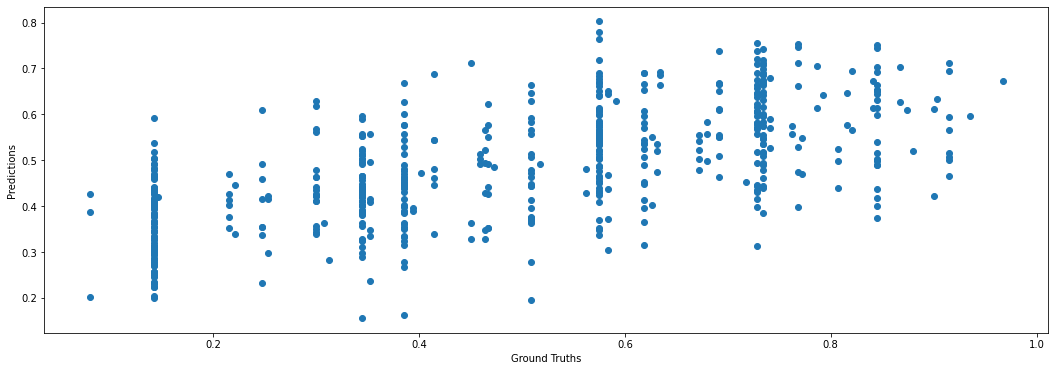

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
book_names = book_and_averaged_chunk_df["book_name"].values

book_and_averaged_chunk_df = book_and_averaged_chunk_df.drop(columns=["book_name"])
book_and_averaged_chunk_df = book_and_averaged_chunk_df[[column for column in book_and_averaged_chunk_df.columns if "average_sentence_embedding" not in column]]
best_features = book_and_averaged_chunk_df.columns[np.argwhere((rfe.ranking_ <= 13) == True).T[0]].tolist()
book_and_averaged_chunk_df = book_and_averaged_chunk_df[best_features]

df = book_and_averaged_chunk_df
df["y"] = np.array([labels[book_name] for book_name in book_names])
df["book_name"] = book_names

all_predictions = []
all_labels = []
train_mses = []
train_maes = []
validation_mses = []
validation_maes = []

book_names_splitted = np.array_split(book_names, 10)
for index, split in enumerate(book_names_splitted):
    train_df = df[~df["book_name"].isin(split)]
    validation_df = df[df["book_name"].isin(split)]
    train_X = train_df.drop(columns=["y", "book_name"]).values
    train_y = train_df["y"].values.ravel()
    validation_X = validation_df.drop(columns=["y", "book_name"]).values
    validation_y = validation_df["y"].values.ravel()
    dtrain = xgboost.DMatrix(train_X, label=train_y)
    params = {"max_depth": 5, "learning_rate": 0.01, "colsample_bytree": 0.5, "min_child_weight": 6.0, "n_jobs": -1}
    model = xgboost.train(
        params,
        dtrain,
        num_boost_round=num_boost_round
    )

    train_books = deepcopy(train_df[["book_name", "y"]])
    train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
    validation_books = deepcopy(validation_df[["book_name", "y"]])
    validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))

    train_books = train_books.groupby("book_name").mean()
    validation_books = validation_books.groupby("book_name").mean()

    train_y = train_books["y"].tolist()
    train_yhat = train_books["yhat"].tolist()
    validation_y = validation_books["y"].tolist()
    validation_yhat = validation_books["yhat"].tolist()

    all_labels.extend(validation_y)
    all_predictions.extend(validation_yhat)

    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    train_mses.append(train_mse)
    train_maes.append(train_mae)
    validation_mses.append(validation_mse)
    validation_maes.append(validation_mae)
    print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

mean_train_mse = np.mean(train_mses)
mean_train_mae = np.mean(train_maes)
mean_validation_mse = np.mean(validation_mses)
mean_validation_mae = np.mean(validation_maes)


print("------")
print(f"Mean scores, TrainMSE: {np.round(mean_train_mse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}")

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.xlabel("Ground Truths")
plt.ylabel("Predictions")

plt.show();
